In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

Key Points Using Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=3), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)
                             ) 

Extract Keypoint Values

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

Setup Folders for Collection

In [6]:
path = os.getcwd()
DATA_PATH = os.path.join('Dataset') 

# Action Lists
actions = np.array(['halo', 'apa kabar', 'aku', 'kamu', 'maaf', 'tolong', 'ya', 'tidak', 'suka', 'makanan', 
                    'selamat pagi', 'selamat siang', 'selamat sore', 'selamat malam', 'sampai jumpa lagi', 
                    'perkenalkan', 'terima kasih', 'sama-sama', 'mau', 'tidak mau'])

# num videos worth of data
no_sequences = 40

# Videos are going to be num frames in length
sequence_length = 30

Create Video Samples

Preprocess Data and Create Labels and Features

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [8]:
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'halo': 0,
 'apa kabar': 1,
 'aku': 2,
 'kamu': 3,
 'maaf': 4,
 'tolong': 5,
 'ya': 6,
 'tidak': 7,
 'suka': 8,
 'makanan': 9,
 'selamat pagi': 10,
 'selamat siang': 11,
 'selamat sore': 12,
 'selamat malam': 13,
 'sampai jumpa lagi': 14,
 'perkenalkan': 15,
 'terima kasih': 16,
 'sama-sama': 17,
 'mau': 18,
 'tidak mau': 19}

In [28]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [ ]:
# WINDOW_SIZE = 10  # Number of frames in each input window
# STRIDE = 5  # Shift of the window

# X = []  # Store sequences
# y = []  # Store labels

# for action in actions:  # Iterate through action labels
#     action_path = os.path.join(DATA_PATH, action)
    
#     for iteration in os.listdir(action_path):
#         iteration_path = os.path.join(action_path, iteration)
#         frames = []
        
#         for frame_file in sorted(os.listdir(iteration_path)):  # Ensure correct order
#             frame_path = os.path.join(iteration_path, frame_file)
#             frame_data = np.load(frame_path)  # Shape (258,)
#             frames.append(frame_data)
        
#         # Apply sliding window
#         num_frames = len(frames)
#         for start in range(0, num_frames - WINDOW_SIZE + 1, STRIDE):
#             window = frames[start:start + WINDOW_SIZE]  # Extract window
#             X.append(window)  # Shape: (WINDOW_SIZE, 258)
#             y.append(label_map[action])  # Map action label to number

# X = np.array(X)  # Shape: (num_windows, WINDOW_SIZE, 258)
# y = np.array(y)  # Shape: (num_windows,)

In [ ]:
# X.shape

(2000, 10, 258)

In [ ]:
# y.shape

(2000,)

In [29]:
np.array(sequences).shape

(800, 30, 258)

In [30]:
np.array(labels).shape

(800,)

In [31]:
X = np.array(sequences)
X.shape

(800, 30, 258)

In [32]:
y = to_categorical(labels, num_classes=len(actions))  # Shape: (num_frames, num_classes)
# y = to_categorical(y, num_classes=len(actions))  # Shape: (num_windows, num_classes)
y.shape

(800, 20)

In [33]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [34]:
print("X_train.shape: ", X_train.shape) # (num_windows, WINDOW_SIZE, 258)
print("y_train.shape: ", y_train.shape) # (num_windows, num_classes)

X_train.shape:  (640, 30, 258)
y_train.shape:  (640, 20)


Build and Train LSTM Neural Network

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

In [172]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,258)))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(32, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [ ]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 258)))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True, activation='relu'))
# model.add(Dropout(0.2))
# model.add(LSTM(32, return_sequences=False, activation='relu'))  # Reduce last LSTM units
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(actions), activation='softmax'))  # Output layer

In [ ]:
# model = Sequential()
# model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(10, 258)))
# model.add(Dropout(0.2))  # Dropout inside LSTM
# model.add(BatchNormalization())

# model.add(LSTM(64, return_sequences=True, activation='relu'))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

# model.add(LSTM(32, return_sequences=False, activation='relu'))  # Smaller last LSTM layer
# model.add(Dropout(0.3))  # Increase dropout before Dense layers

# model.add(Dense(64, activation='relu'))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(len(actions), activation='softmax'))

In [173]:
# model.compile(optimizer='Adam)', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Use validation set for monitoring
    epochs=300,  
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/300
20/20 [==============================] - 31s 267ms/step - loss: 2.9850 - categorical_accuracy: 0.0578 - val_loss: 2.9218 - val_categorical_accuracy: 0.0938 - lr: 0.0010
Epoch 2/300
20/20 [==============================] - 3s 175ms/step - loss: 2.8953 - categorical_accuracy: 0.0891 - val_loss: 2.9432 - val_categorical_accuracy: 0.1250 - lr: 0.0010
Epoch 3/300
20/20 [==============================] - 3s 134ms/step - loss: 2.6845 - categorical_accuracy: 0.1750 - val_loss: 2.8889 - val_categorical_accuracy: 0.2438 - lr: 0.0010
Epoch 4/300
20/20 [==============================] - 2s 114ms/step - loss: 2.5061 - categorical_accuracy: 0.2297 - val_loss: 2.6984 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 5/300
20/20 [==============================] - 2s 94ms/step - loss: 2.2972 - categorical_accuracy: 0.2969 - val_loss: 2.3946 - val_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 6/300
20/20 [==============================] - 2s 110ms/step - loss: 2.1255 - categorical_accu

In [175]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_36 (LSTM)              (None, 30, 64)            82688     
                                                                 
 dropout_26 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_37 (LSTM)              (None, 30, 64)            33024     
                                                                 
 dropout_27 (Dropout)        (None, 30, 64)            0         
                                                                 
 lstm_38 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_28 (Dropout)        (None, 32)                0         
                                                                 
 batch_normalization_12 (Ba  (None, 32)              

Make Predictions

In [176]:
res = model.predict(X_test)

5/5 [==============================] - 3s 29ms/step


In [177]:
actions[np.argmax(res[1])]

'tidak mau'

In [178]:
actions[np.argmax(y_test[1])]

'tidak mau'

Save Model

In [185]:
model.save('Models/model_normal_seq_2.h5')

d:\python\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load_weights('Models/model_normal_seq_2.h5')

Convert model to jason

Evaluation using Confusion Matrix and Accuracy

In [179]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [180]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

multilabel_confusion_matrix(ytrue, yhat)

5/5 [==============================] - 0s 26ms/step


array([[[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[151,   1],
        [  1,   7]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[151,   1],
        [  1,   7]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]],

       [[152,   0],
        [  0,   8]]], dtype=int64)

In [181]:
accuracy_score(ytrue, yhat)

0.9875

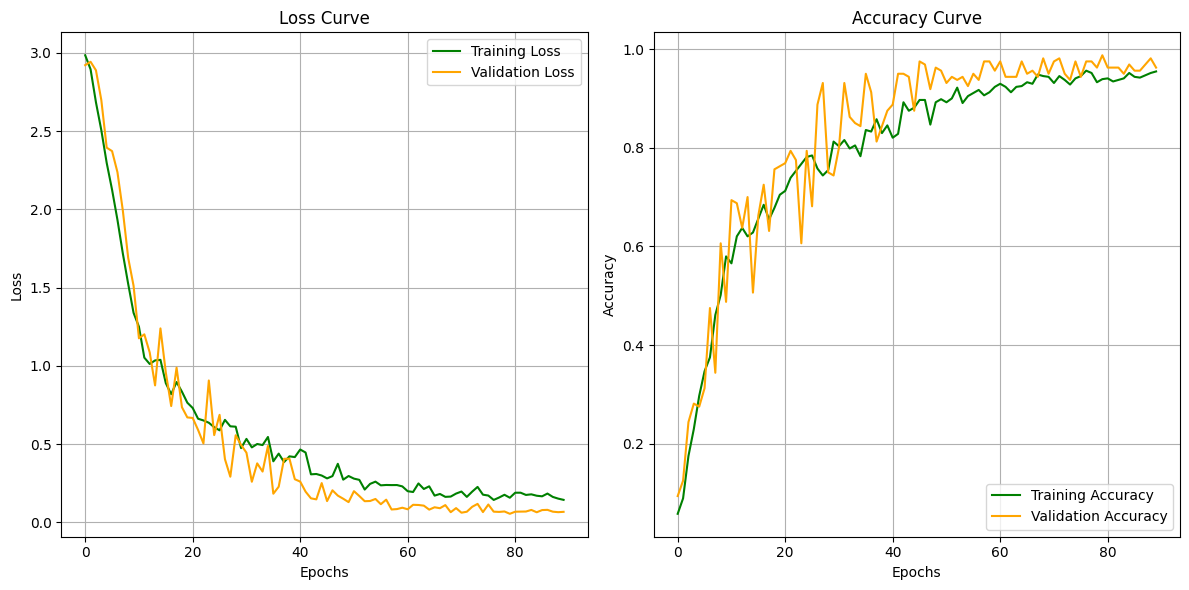

In [184]:
# Plot training loss and training accuracy
plt.figure(figsize=(12, 6))

# Plotting training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

# Plotting validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid(True)

# Plotting Validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

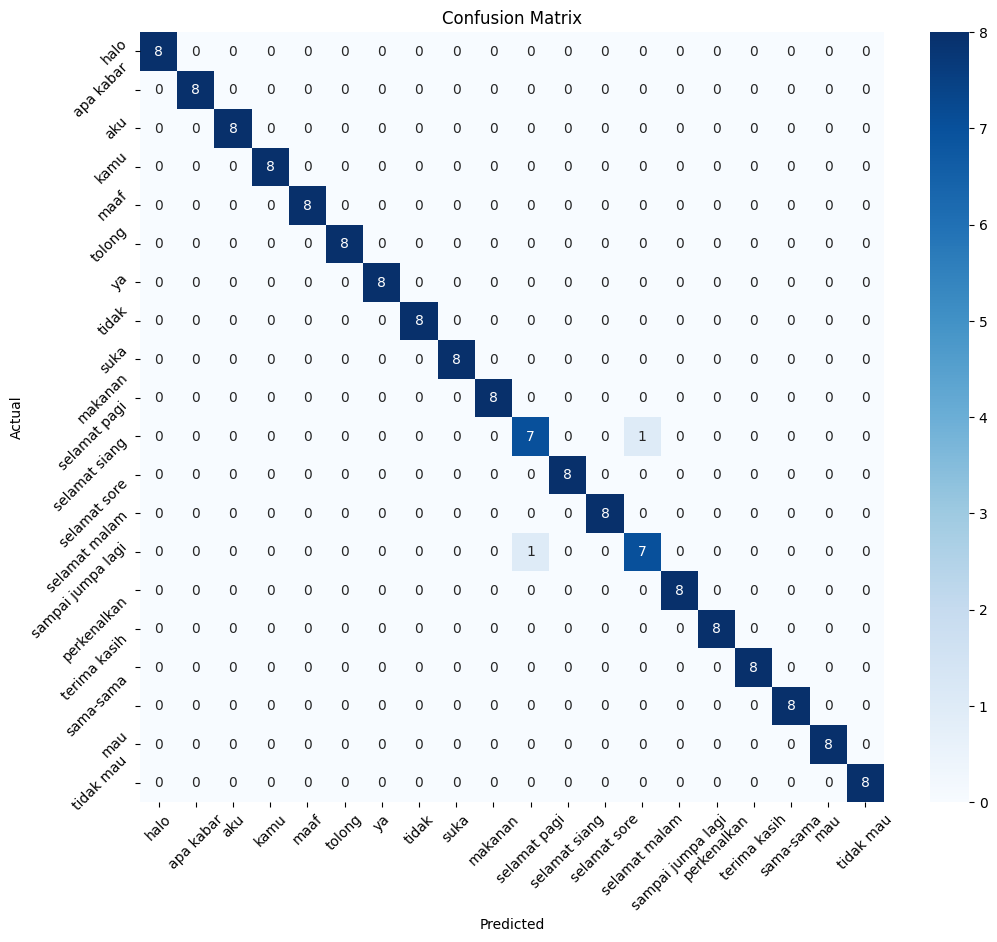


Precision: 0.9875
Recall: 0.9875
F1 Score: 0.9875

Classification Report:
                    precision    recall  f1-score   support

             halo       1.00      1.00      1.00         8
        apa kabar       1.00      1.00      1.00         8
              aku       1.00      1.00      1.00         8
             kamu       1.00      1.00      1.00         8
             maaf       1.00      1.00      1.00         8
           tolong       1.00      1.00      1.00         8
               ya       1.00      1.00      1.00         8
            tidak       1.00      1.00      1.00         8
             suka       1.00      1.00      1.00         8
          makanan       1.00      1.00      1.00         8
     selamat pagi       0.88      0.88      0.88         8
    selamat siang       1.00      1.00      1.00         8
     selamat sore       1.00      1.00      1.00         8
    selamat malam       0.88      0.88      0.88         8
sampai jumpa lagi       1.00      1.00

In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

# Convert predictions & labels to integer class indices
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(res, axis=1).tolist()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Define class labels for the heatmap
class_labels = list(label_map.keys())  # Get sign language action labels

# Plot Confusion Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Precision, Recall, F1-Score, and accuration
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print("\nPrecision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_labels))